## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence, code_to_sequence
from denoiser import Denoiser
from utils import load_code_dict, load_filepaths_and_text

/data/sls/u/wnhsu/code/tacotron2_factory/tacotron2_20191017_dev/plotting_utils.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/sls/u/wnhsu/vtenvs/pt1.3_cp36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/sls/u/wnhsu/vtenvs/pt1.3_cp36/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/data/sls/u/wnhsu/vtenvs/pt1.3_cp36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 563

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
import json
# ckpt_args_path = './exps/spkemb_vctk_run1/args.json'
ckpt_args_path = './exps/lat64_vctk_run1/args.json'

hparams = create_hparams()
with open(ckpt_args_path, 'r') as f:
    args_dict = json.load(f)
for k in args_dict:
    assert(hasattr(hparams, k)) 
    if getattr(hparams, k) != args_dict[k]:
        print('setting %20s from %20s to %20s' % ( 
            k, getattr(hparams, k), args_dict[k]))
        setattr(hparams, k, args_dict[k])

hparams.distributed_run = False

setting                 seed from                 6789 to                 1234
setting      distributed_run from                False to                 True
setting             dist_url from tcp://localhost:54321 to tcp://localhost:54324
setting       training_files from filelists/ljs_audio_text_train_filelist.txt to ./filelists/vctk_trimmed_train_filelist.txt
setting     validation_files from filelists/ljs_audio_text_val_filelist.txt to ./filelists/vctk_trimmed_valid_filelist.txt
setting              lat_dim from                    0 to                   64
setting           batch_size from                   64 to                   24


#### Load model from checkpoint

In [4]:
checkpoint_path = "./exps/lat64_klw0.01_vctk_run1/checkpoint_125000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [5]:
waveglow_path = './pretrained/waveglow_256channels_new.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Prepare text input

In [6]:
# data = load_filepaths_and_text("filelists/rdvq_01000_01100/places_eng_400k_train_filelist.txt")
# code_dict = load_code_dict(hparams.code_dict)
# idx = 4
# code = data[idx][hparams.code_key].split()
# print('(TEXT LEN=%d) %s' % (len(data[idx]['text']), data[idx]['text']))
# print('(CODE LEN=%d) %s' % (len(code), ' '.join(code)))
# sequence = np.array(code_to_sequence(code, code_dict, True))[None, :]
# sequence = torch.autograd.Variable(
#     torch.from_numpy(sequence)).cuda().long()
# ipd.display(ipd.Audio(data[idx]['audio']))

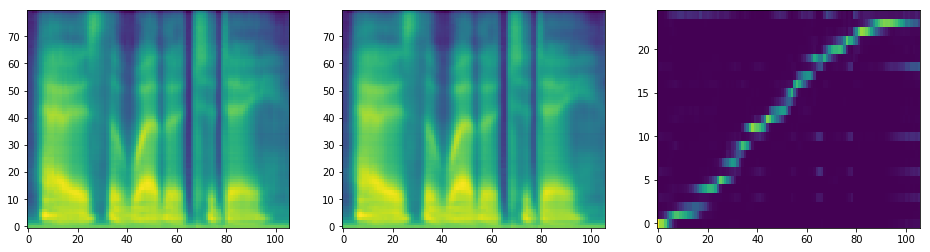

In [7]:
text = "How is the weather today?"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))
plt.show()

with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))

audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.display(ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate))

tensor([0], device='cuda:0')
tensor([[-0.8008,  0.4016,  0.4607,  0.5889, -0.1292,  0.0215,  0.2896,  0.0351,
          0.0615,  0.3831, -0.2578, -0.1606,  0.3633, -0.9731, -0.0699,  0.3296,
          0.1425, -0.0106, -0.5137, -0.4478,  0.3635,  0.0301,  0.7188,  0.3628,
          0.2192,  0.4258, -0.6016, -1.1318,  1.1943,  0.0126, -0.4585,  0.7217,
          0.0166, -0.7188,  0.6846,  0.1823, -0.4468,  0.0461,  0.7021, -0.3325,
          0.0770,  0.8989, -0.0363, -0.6978,  0.7065,  0.6426, -0.3057, -0.0076,
         -0.1873,  0.0875, -1.2510, -0.7163,  0.6353,  0.4788, -0.0198, -0.2566,
          0.4377,  0.9736,  0.6523,  0.7178,  0.4495,  0.7842, -0.2021,  1.4033]],
       device='cuda:0', dtype=torch.float16)


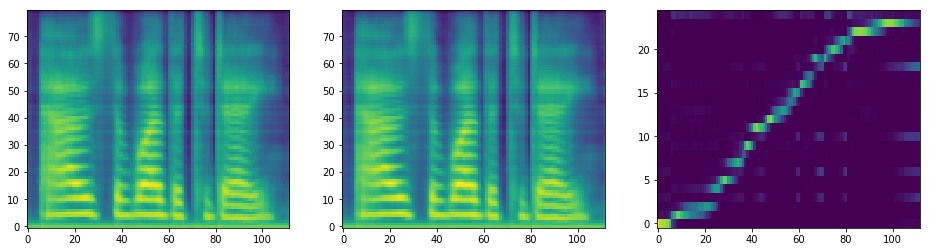

In [12]:
obs_labels = torch.LongTensor(1).cuda().fill_(0)
print(obs_labels)

lat = torch.FloatTensor(1, hparams.lat_dim).cuda().zero_()
lat = lat.normal_() * 0.5
lat = lat.type(model.embedding.weight.type())
print(lat)

text = "How is the weather today?"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence, obs_labels, lat)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))
plt.show()

with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))

audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.display(ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate))

#### Decode text input and plot results

In [9]:
# mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence, obs_labels, lat)
# plot_data((mel_outputs.float().data.cpu().numpy()[0],
#            mel_outputs_postnet.float().data.cpu().numpy()[0],
#            alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [10]:
# with torch.no_grad():
#     audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
# ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [11]:
# audio_denoised = denoiser(audio, strength=0.01)[:, 0]
# ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 